In [16]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig

from torch._tensor import Tensor
import importlib


from botorch.models import SingleTaskGP
import math
import importlib

from src import GPVisualiser
from botorch.models import SingleTaskGP
importlib.reload(GPVisualiser)


<module 'src.GPVisualiser' from 'c:\\GitHub\\BO-Coli\\src\\GPVisualiser.py'>

In [17]:
n_dims = 2
dim_names = [f"x{i}" for i in range(n_dims)]
simple_func = lambda x: sum(torch.sqrt(x))
resp = ResponseFunction(simple_func, n_dims)
resp.evaluate(torch.tensor([1., 4]))

tensor(3.)

In [18]:
from typing import Literal
import pandas as pd
import seaborn as sns


from src.ax_helper import get_guess_coords

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### Linear param sobol:

[INFO 09-17 13:25:37] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-17 13:25:37] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 13:25:37] ax.api.client: Generated new trial 1 with parameters {'x0': 3.249654, 'x1': 8.593074} using GenerationNode Sobol.
[INFO 09-17 13:25:37] ax.api.client: Generated new trial 2 with parameters {'x0': 42.751121, 'x1': 56.484755} using GenerationNode Sobol.
[INFO 09-17 13:25:37] ax.api.client: Generated new tri

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   3.249654   8.593074
2         2_0  42.751121  56.484755
3         3_0  27.816991   1.778017
4         4_0   2.114164  11.613334
5         5_0   1.020939   2.671599
6         6_0  13.432945  18.122238
7         7_0  87.343126   5.504455
8         8_0   6.639242  37.439484
9         9_0   9.288113   1.159541
10       10_0  68.097580  17.653160
11       11_0  10.502557   5.657225
12       12_0   1.432286  86.548771
13       13_0   2.903296   3.720339
14       14_0  21.289050  54.882390
15       15_0  32.847528   1.823719
16       16_0   4.480214  26.794998
17       17_0   5.236139   2.169097
18       18_0  40.161229  29.773152
19       19_0  19.571975   3.361372
20       20_0   2.552113  45.962041
21       21_0   1.675119   6.758933
22       22_0  12.846373  95.737473
23       23_0  62.578488   1.042969
24       24_0   8.158851  14.850764
25       25_0   6.313116   4.583957
26       26_0  85.336203  33

<Axes: xlabel='x0', ylabel='x1'>

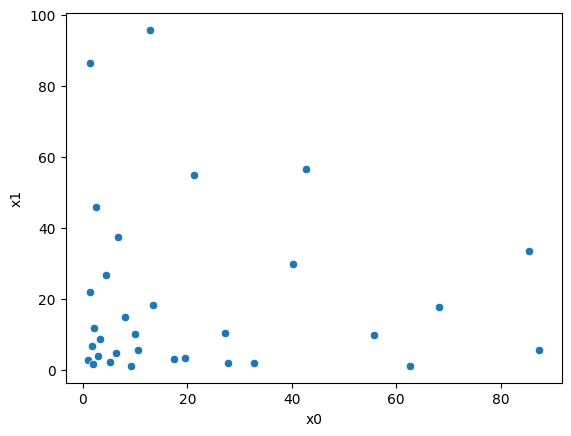

In [19]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(n_dims)
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### Log parameters sobol

[INFO 09-17 13:25:38] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-17 13:25:38] ax.api.client: Generated new trial 0 with parameters {'x0': 50.5, 'x1': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 13:25:38] ax.api.client: Generated new trial 1 with parameters {'x0': 43.078129, 'x1': 57.388664} using GenerationNode Sobol.
[INFO 09-17 13:25:38] ax.api.client: Generated new trial 2 with parameters {'x0': 86.475361, 'x1': 2.604677} using GenerationNode Sobol.
[INFO 09-17 13:25:38] ax.api.client: Generated new tr

  trial_name         x0         x1
0        0_0  50.500000  50.500000
1        1_0  43.078129  57.388664
2        2_0  86.475361   2.604677
3        3_0  70.424536  75.433039
4        4_0   1.890589  34.087495
5        5_0  18.158179  97.617978
6        6_0  61.942141  42.815935
7        7_0  95.004599  66.159309
8        8_0  26.857358  24.795753
9        9_0  34.983555  83.588750


<Axes: xlabel='x0', ylabel='x1'>

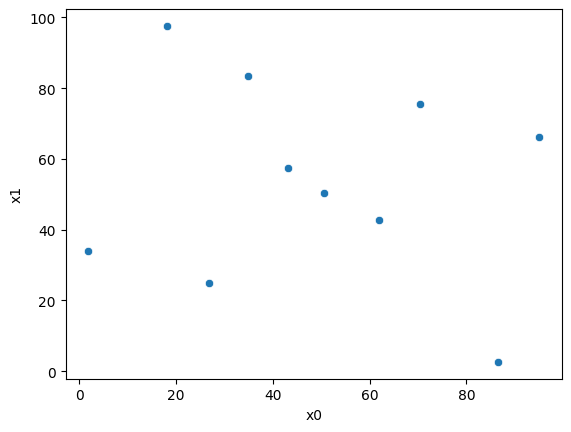

In [20]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
           # scaling = 'log',
        ) for i in range(n_dims)
    ],
)


client.configure_optimization(objective="response")

client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

A nice and informative initial guess grid is formed

In [21]:
from src import ax_helper
importlib.reload(ax_helper)

<module 'src.ax_helper' from 'c:\\GitHub\\BO-Coli\\src\\ax_helper.py'>

In [22]:
for trial in client._experiment.trials.items():
    print(trial)

(0, Trial(experiment_name='batch_bo_test', index=0, status=TrialStatus.RUNNING, arm=Arm(name='0_0', parameters={'x0': 50.5, 'x1': 50.5})))
(1, Trial(experiment_name='batch_bo_test', index=1, status=TrialStatus.RUNNING, arm=Arm(name='1_0', parameters={'x0': 43.07812863588333, 'x1': 57.38866376876831})))
(2, Trial(experiment_name='batch_bo_test', index=2, status=TrialStatus.RUNNING, arm=Arm(name='2_0', parameters={'x0': 86.47536138724536, 'x1': 2.604677149094641})))
(3, Trial(experiment_name='batch_bo_test', index=3, status=TrialStatus.RUNNING, arm=Arm(name='3_0', parameters={'x0': 70.42453646659851, 'x1': 75.4330387711525})))
(4, Trial(experiment_name='batch_bo_test', index=4, status=TrialStatus.RUNNING, arm=Arm(name='4_0', parameters={'x0': 1.8905889298766851, 'x1': 34.08749542944133})))
(5, Trial(experiment_name='batch_bo_test', index=5, status=TrialStatus.RUNNING, arm=Arm(name='5_0', parameters={'x0': 18.158178525045514, 'x1': 97.61797759868205})))
(6, Trial(experiment_name='batch_bo

In [23]:
ax_helper.get_obs_from_client(client, response_col='response')


,trial_name,x0,x1,response
0,0_0,50.500000,50.500000,NaN
1,1_0,43.078129,57.388664,NaN
2,2_0,86.475361,2.604677,NaN
3,3_0,70.424536,75.433039,NaN
4,4_0,1.890589,34.087495,NaN
5,5_0,18.158179,97.617978,NaN
6,6_0,61.942141,42.815935,NaN
7,7_0,95.004599,66.159309,NaN
8,8_0,26.857358,24.795753,NaN
9,9_0,34.983555,83.588750,NaN


In [24]:
ax_helper.get_obs_from_client(client, response_col='response')

,trial_name,x0,x1,response
0,0_0,50.500000,50.500000,NaN
1,1_0,43.078129,57.388664,NaN
2,2_0,86.475361,2.604677,NaN
3,3_0,70.424536,75.433039,NaN
4,4_0,1.890589,34.087495,NaN
5,5_0,18.158179,97.617978,NaN
6,6_0,61.942141,42.815935,NaN
7,7_0,95.004599,66.159309,NaN
8,8_0,26.857358,24.795753,NaN
9,9_0,34.983555,83.588750,NaN


[INFO 09-17 13:25:38] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-17 13:25:38] ax.api.client: Generated new trial 10 with parameters {'x0': 100.0, 'x1': 85.172565} using GenerationNode MBM.
[WARNING 09-17 13:25:38] ax.api.client: 6 trials requested but only 1 could be generated.
c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWa

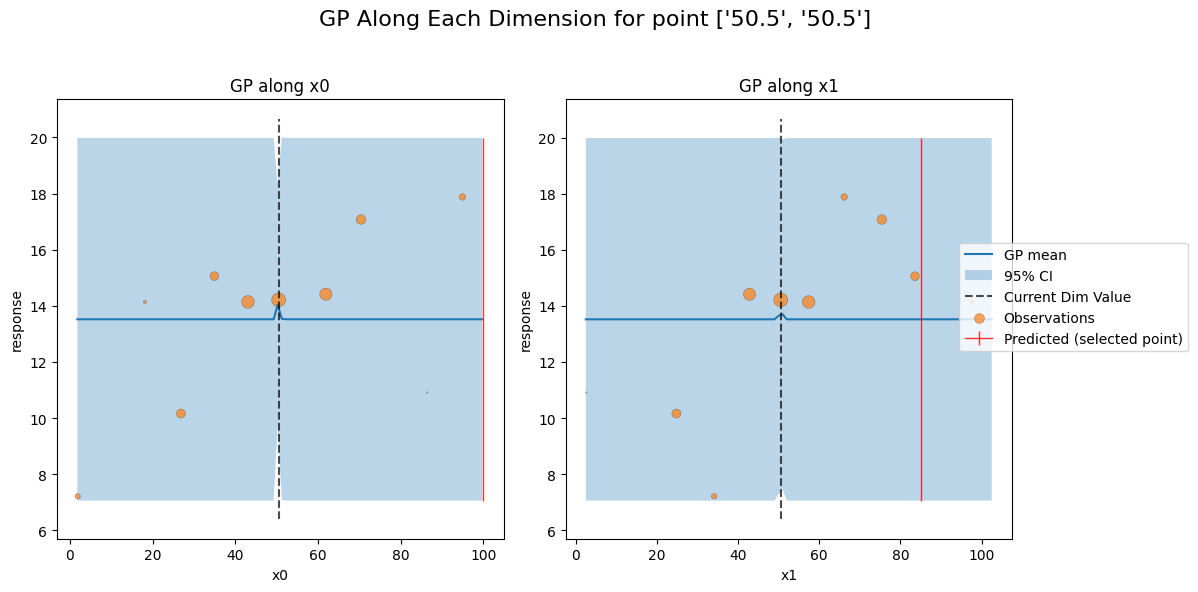

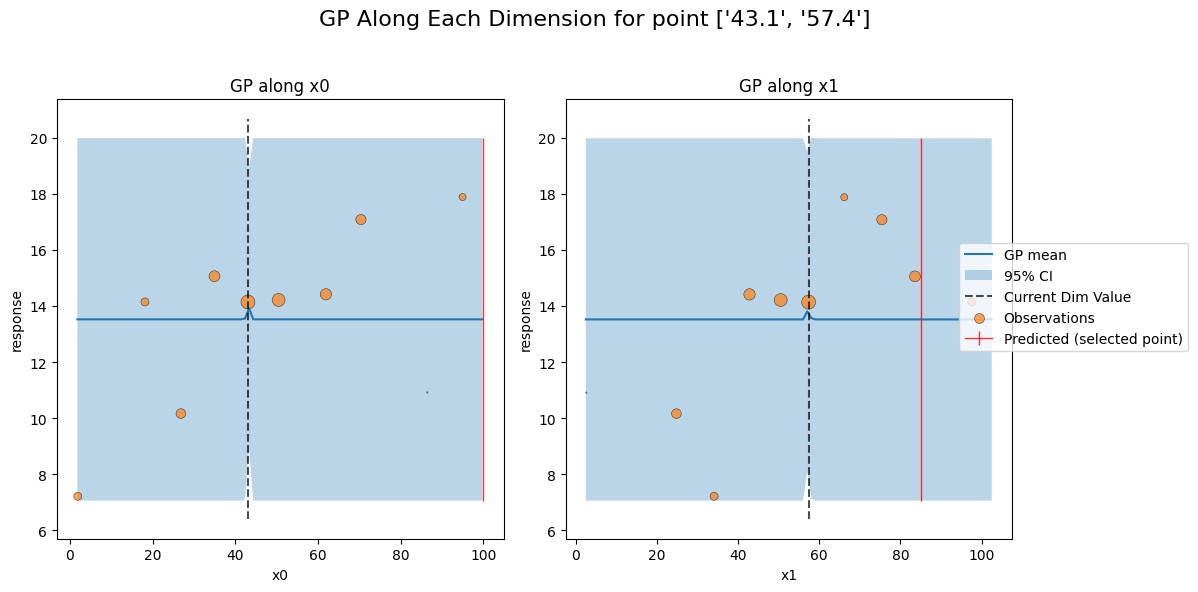

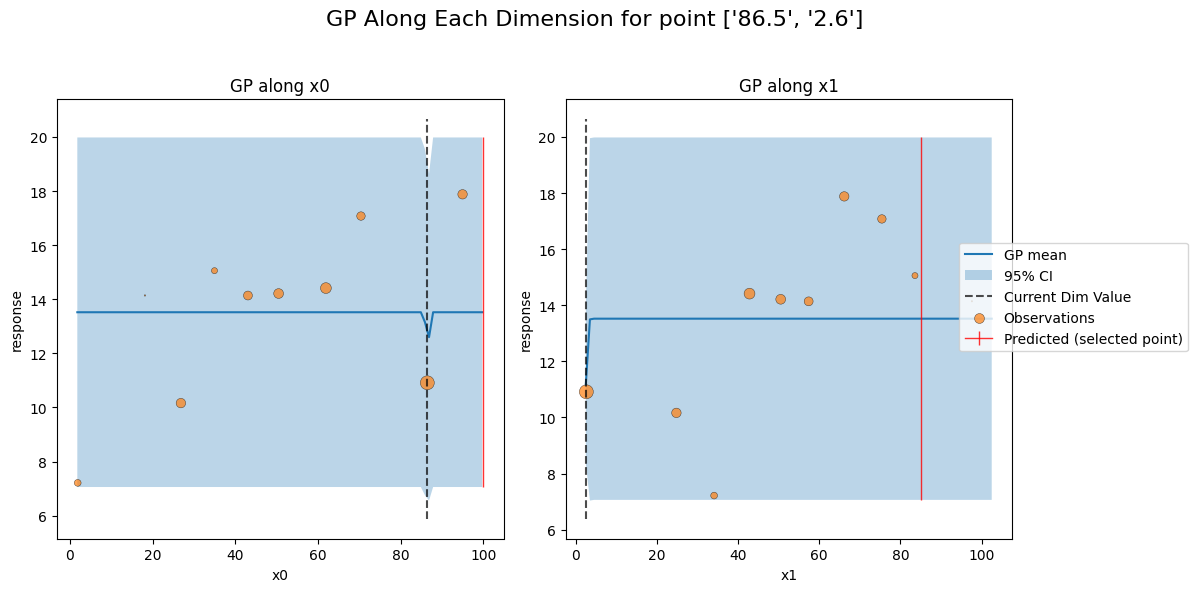

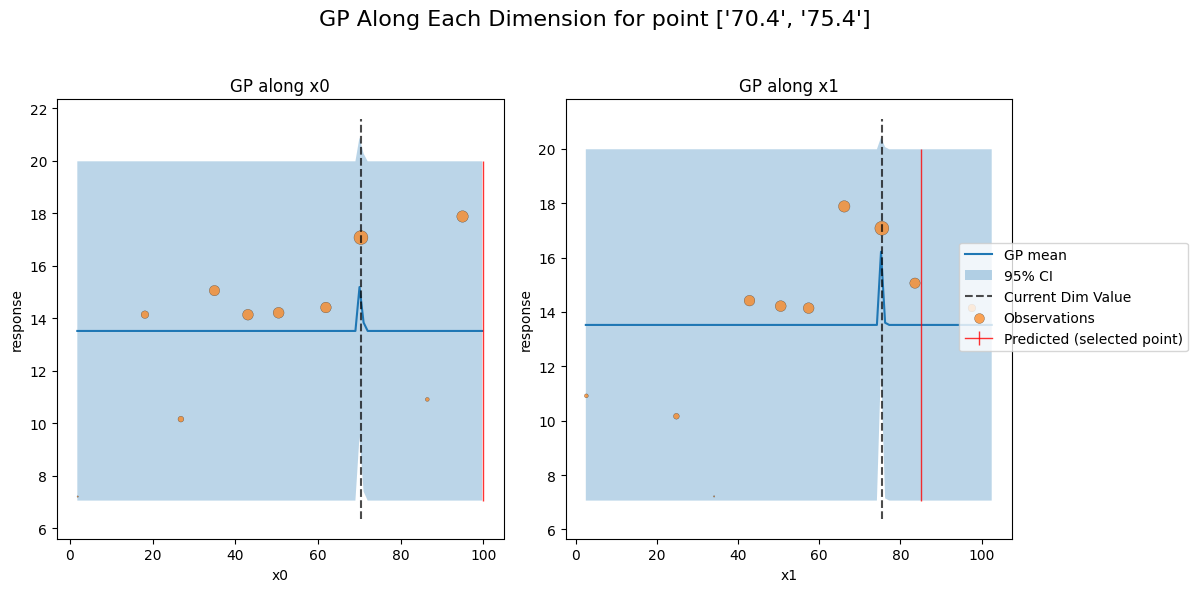

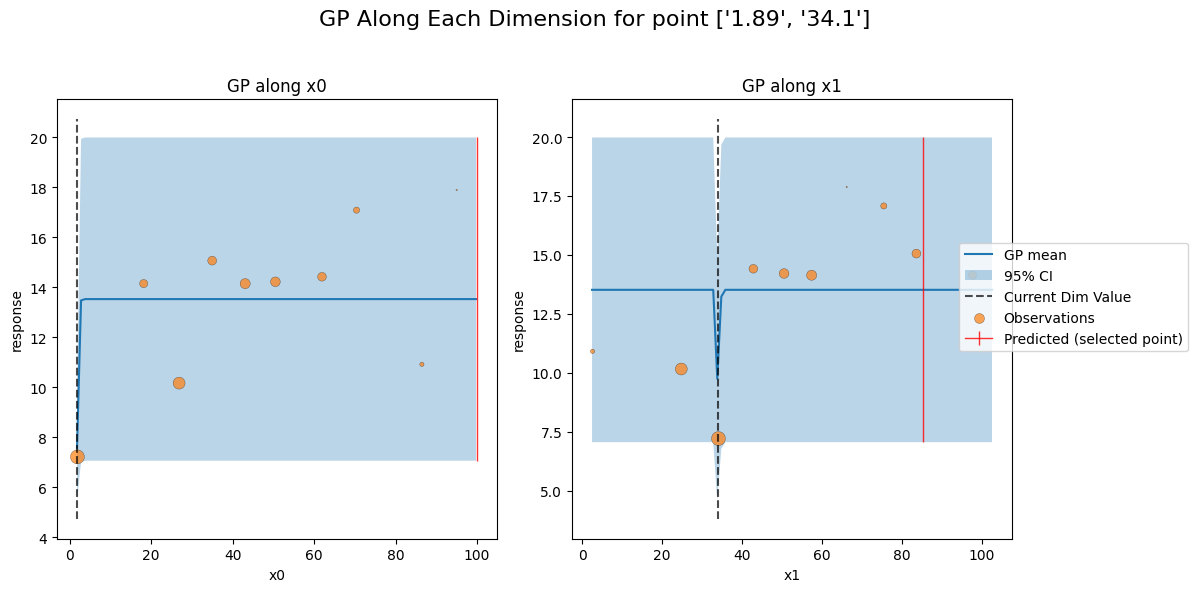

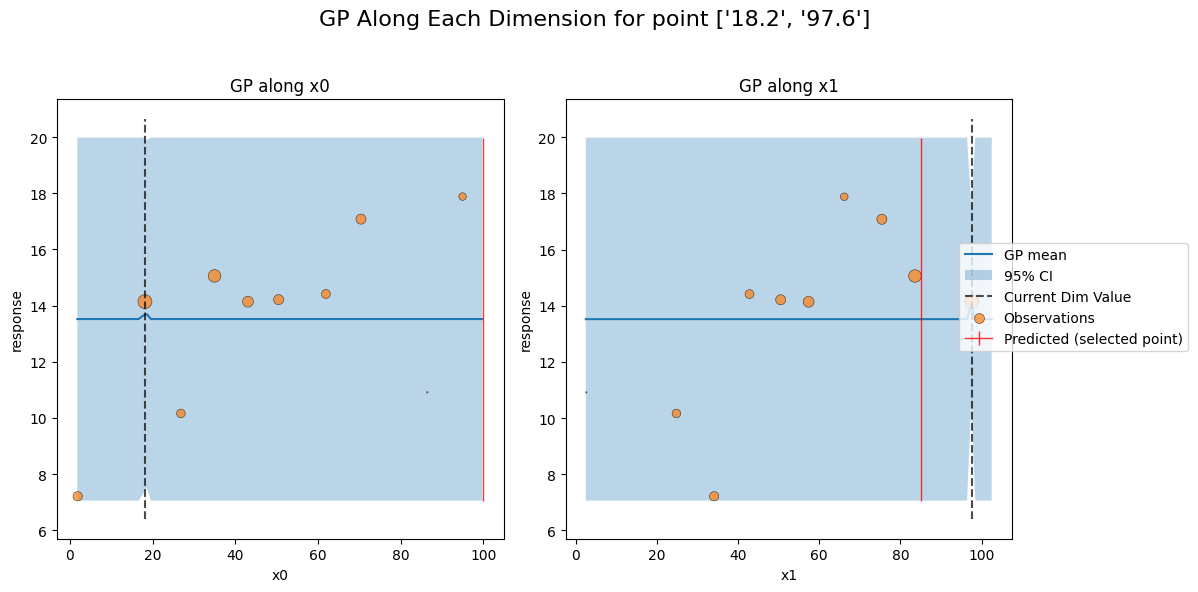

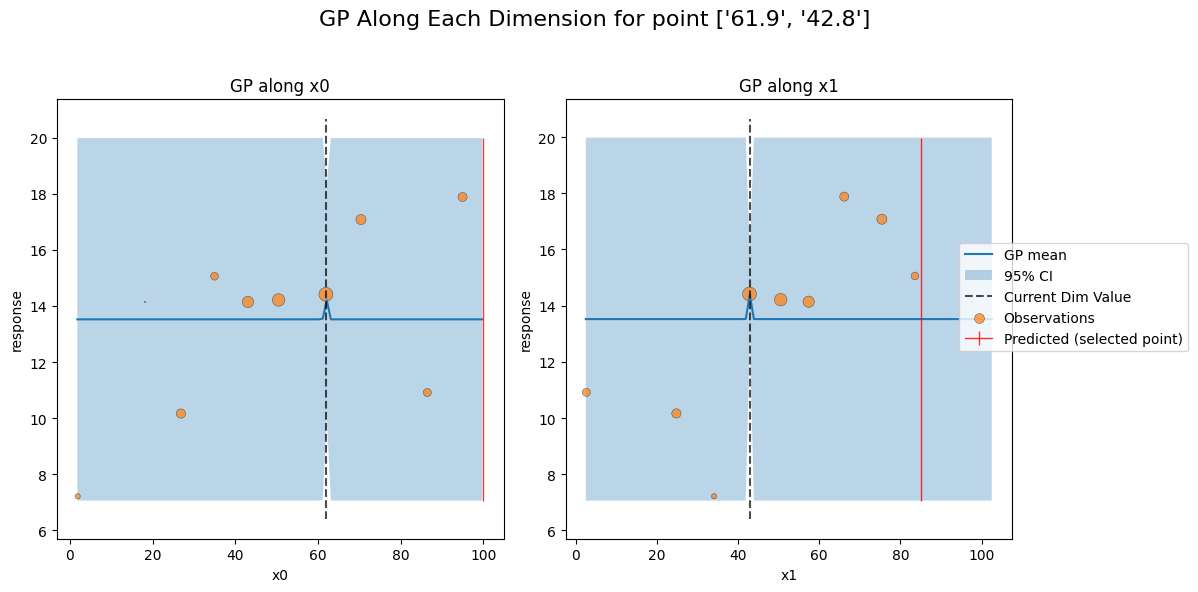

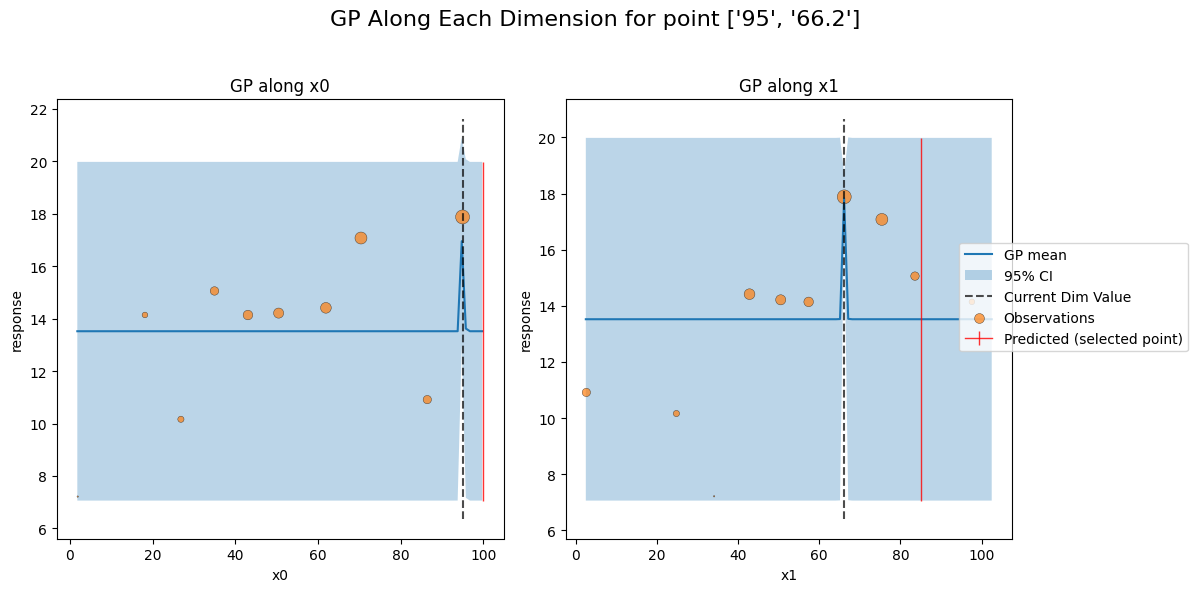

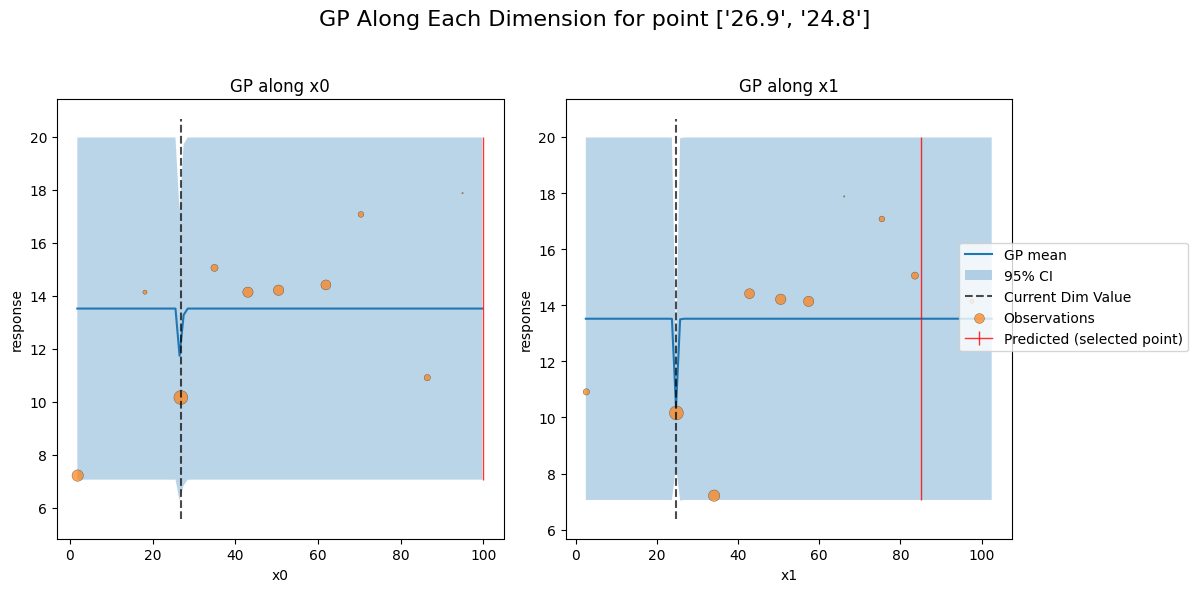

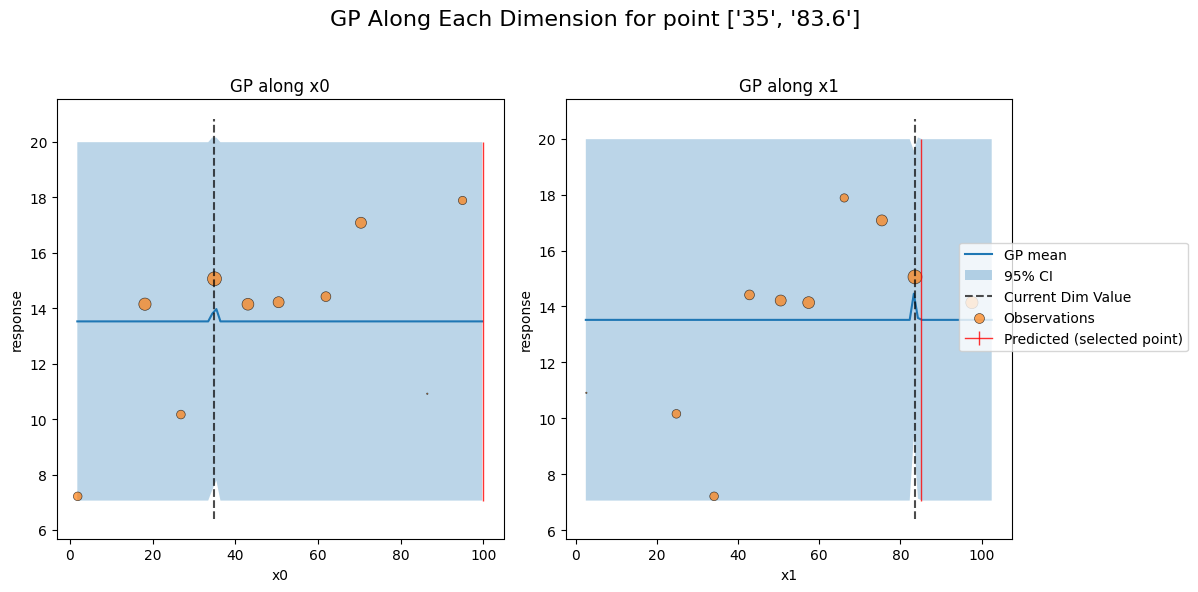

In [25]:
importlib.reload(GPVisualiser)


for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):


        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})




client.get_next_trials(max_trials=6)

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response')


for i, trial in obs.iterrows():
    if not pd.isna(trial['response']):

        coords = trial.loc[dim_names]
        plotter.plot_all(torch.tensor(coords))

        continue

In [26]:
obs = ax_helper.get_obs_from_client(client, response_col='response')
obs.tail(3)

,trial_name,x0,x1,response
8,8_0,26.857358,24.795753,10.161942
9,9_0,34.983555,83.588750,15.057378
10,10_0,100.000000,85.172565,NaN


In [27]:
client.get_next_trials(max_trials=5)

[INFO 09-17 13:25:43] ax.api.client: Generated new trial 11 with parameters {'x0': 100.0, 'x1': 100.0} using GenerationNode MBM.
[INFO 09-17 13:25:43] ax.api.client: Generated new trial 12 with parameters {'x0': 100.0, 'x1': 73.022275} using GenerationNode MBM.
[INFO 09-17 13:25:43] ax.api.client: Generated new trial 13 with parameters {'x0': 100.0, 'x1': 63.416137} using GenerationNode MBM.
[INFO 09-17 13:25:43] ax.api.client: Generated new trial 14 with parameters {'x0': 100.0, 'x1': 78.954654} using GenerationNode MBM.
[INFO 09-17 13:25:43] ax.api.client: Generated new trial 15 with parameters {'x0': 78.93509, 'x1': 100.0} using GenerationNode MBM.


{11: {'x0': 100.0, 'x1': 100.0},
 12: {'x0': 100.0, 'x1': 73.02227496389449},
 13: {'x0': 100.0, 'x1': 63.41613729821534},
 14: {'x0': 100.0, 'x1': 78.95465380967023},
 15: {'x0': 78.93509028550771, 'x1': 100.0}}